In [49]:
#Import Modules
import os, sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import glob
import datetime

In [28]:
dbfile = './DATA/BINA_DATA.db'

# Test if the database file is available in the colab workspace
if os.path.exists(dbfile):
    # Create database (file) and Open a (SQL) connection 
    connection = sqlite3.connect(dbfile)
    # Create a data cursor to exchange information between Python and SQLite
    cursor = connection.cursor()
else:
    print("Angegebene Database wurde nicht gefunden")
    # Create database (file) and Open a (SQL) connection 
    connection = sqlite3.connect(dbfile)
    # Create a data cursor to exchange information between Python and SQLite
    cursor = connection.cursor()
    #sys.exit(0)

In [36]:
electricityProductionPlant = pd.read_sql_query("SELECT * FROM solarPlants", connection)
electricityProductionPlant.head(1000)

,id,xtfID,plz,totalPower,mainCategory,subCategory,plantCategory,_x,_y
0,1,14727,4147,18.81,maincat_2,subcat_2,plantcat_9,2611936.0,1257011.0
1,2,14728,5082,5.80,maincat_2,subcat_2,plantcat_8,2645758.0,1265094.0
2,3,10164,3114,3.00,maincat_2,subcat_2,plantcat_8,2610547.0,1188979.0
3,4,10794,3753,8.40,maincat_2,subcat_2,plantcat_8,2610529.0,1167346.0
4,5,9476,8340,4.80,maincat_2,subcat_2,plantcat_8,2705863.0,1240553.0
...,...,...,...,...,...,...,...,...,...
995,996,18776,2067,9.90,maincat_2,subcat_2,plantcat_9,2564484.0,1209629.0
996,997,10676,6314,8.20,maincat_2,subcat_2,plantcat_8,2687484.0,1220837.0
997,998,9623,1971,50.70,maincat_2,subcat_2,plantcat_9,2595674.0,1123804.0
998,999,18778,8374,29.70,maincat_2,subcat_2,plantcat_8,2712639.0,1252021.0


In [38]:
renewableProductionPlant = electricityProductionPlant[electricityProductionPlant['mainCategory'] == 'maincat_1']
renewableProductionPlant.head(1000)

,id,xtfID,plz,totalPower,mainCategory,subCategory,plantCategory,_x,_y
39,40,13128,9650,1595.0,maincat_1,subcat_1,plantcat_4,2732251.0,1231550.0
58,59,13144,1904,440.0,maincat_1,subcat_1,plantcat_4,2568786.0,1109264.0
63,64,13147,1925,423.0,maincat_1,subcat_1,plantcat_5,2563998.0,1103315.0
65,66,13185,1997,75.0,maincat_1,subcat_1,plantcat_5,2590441.0,1109517.0
73,74,13196,1997,37.0,maincat_1,subcat_1,plantcat_5,2589242.0,1113552.0
...,...,...,...,...,...,...,...,...,...
199548,199549,124879,6035,1040.0,maincat_1,subcat_1,plantcat_2,2670437.0,1218308.0
199615,199616,127939,3426,33.0,maincat_1,subcat_1,plantcat_2,2608411.0,1216318.0
199642,199643,128646,6512,75.0,maincat_1,subcat_1,plantcat_5,2721827.0,1114559.0
199655,199656,129073,6512,6.0,maincat_1,subcat_1,plantcat_5,2721851.0,1114475.0


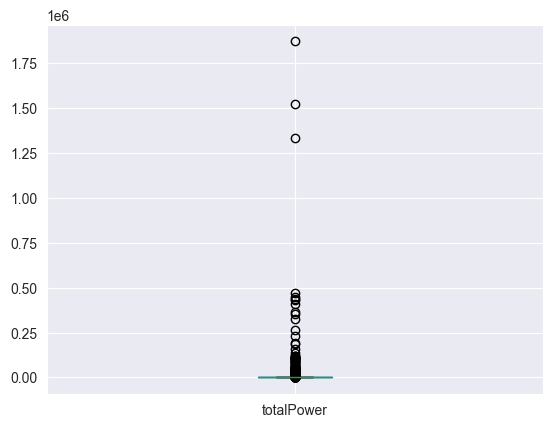

In [40]:
b_plot = renewableProductionPlant.boxplot(column="totalPower")
b_plot.plot()
plt.show()

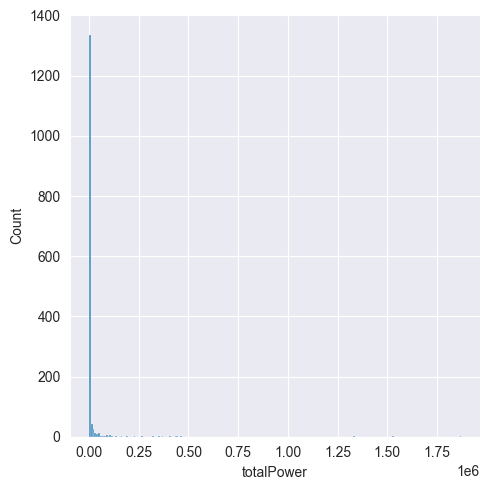

In [41]:
sns.displot(renewableProductionPlant['totalPower'], kde=False, bins=200)
plt.show()

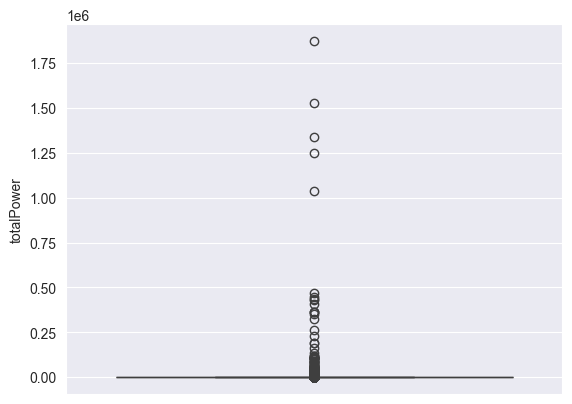

In [42]:
sns.boxplot(data=electricityProductionPlant['totalPower'])
plt.show()

SMARTMETER DATA

In [19]:
df = pd.read_sql_query("SELECT * FROM sumSmartmeter", connection)
smartmeter_df.head()

,area_code,num_meter,value_kwh
timestamp,,,
2022-04-24 05:45:00,6016,85,7.449
2022-04-24 03:30:00,6016,85,11.407
2022-04-29 06:45:00,6016,85,7.546
2022-04-30 21:30:00,6016,85,13.642
2022-04-16 06:15:00,6016,85,13.068


In [23]:
s = smartmeter_df.resample('h').sum()
print(s)

                     area_code  num_meter     value_kwh
timestamp                                              
2020-12-31 23:00:00    3557098     156063  50455.194017
2021-01-01 00:00:00    2654080     156857  45172.072292
2021-01-01 01:00:00    2654080     156873  38297.806292
2021-01-01 02:00:00    2654080     156859  37027.100292
2021-01-01 03:00:00    2654080     156867  32497.362292
...                        ...        ...           ...
2024-03-05 23:00:00     220839       8766   1968.977000
2024-03-06 00:00:00     153312       2695    528.127000
2024-03-06 01:00:00     110295        714    123.850000
2024-03-06 02:00:00      54994        217     43.740000
2024-03-06 03:00:00      18069         81      3.770000

[27845 rows x 3 columns]


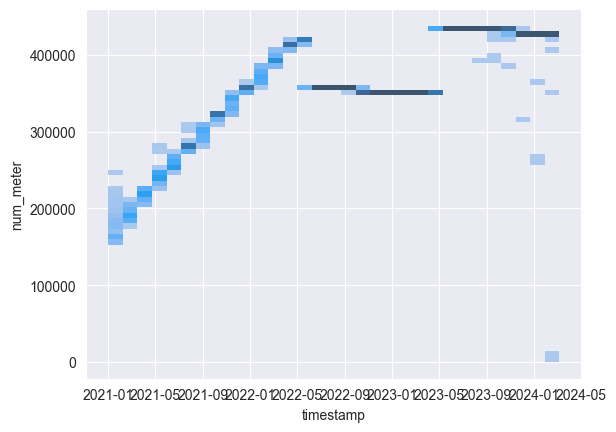

In [27]:
sns.histplot(data=s, x='timestamp', y='num_meter')
plt.show()

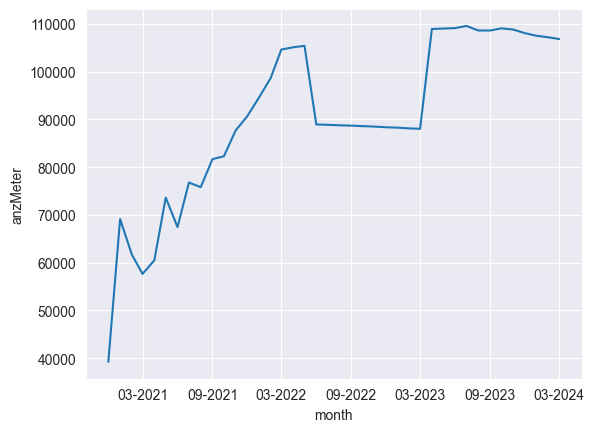

In [53]:
df = pd.read_sql_query("SELECT month, SUM(anzMeter) as anzMeter FROM (SELECT MAX(anzMeter) as anzMeter, STRFTIME('%Y-%m', timestamp) as month FROM smartmeter GROUP BY PLZ, month) GROUP BY month;", connection)
df['month'] = pd.to_datetime(df['month'])
plot = sns.lineplot(data=df, x='month', y='anzMeter')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

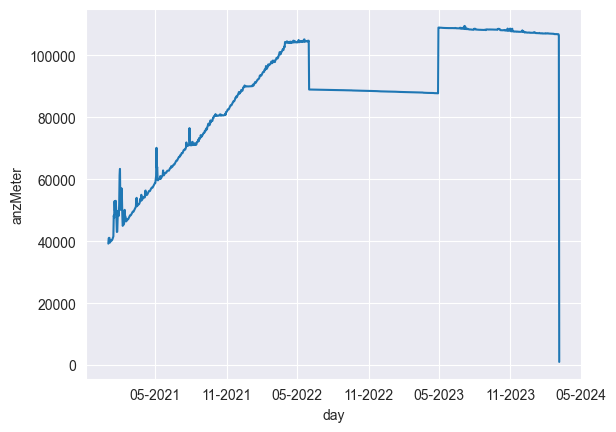

In [54]:
df = pd.read_sql_query("SELECT day, SUM(anzMeter) as anzMeter FROM (SELECT MAX(anzMeter) as anzMeter, STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter GROUP BY PLZ, day) GROUP BY day ORDER BY day;", connection)

df['day'] = pd.to_datetime(df['day'])
plot = sns.lineplot(data=df, x='day', y='anzMeter')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

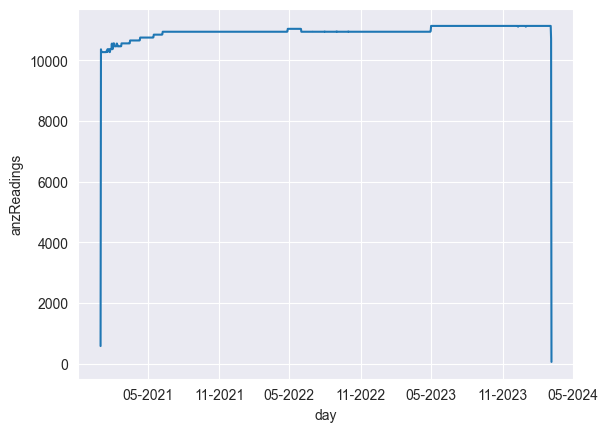

In [55]:
df = pd.read_sql_query("SELECT COUNT(plz) as anzReadings, STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter GROUP BY day;", connection)
df['day'] = pd.to_datetime(df['day'])
plot = sns.lineplot(data=df, x='day', y='anzReadings')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

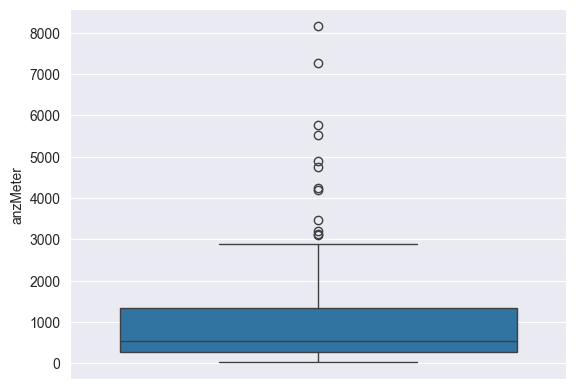

In [45]:
df = pd.read_sql_query("SELECT s.plz, max(anzMeter) as anzMeter, cityName FROM smartmeter s LEFT JOIN plzBfsMapping p ON s.plz = p.plz GROUP BY s.plz;", connection)
sns.boxplot(data=df['anzMeter'])
plt.show()

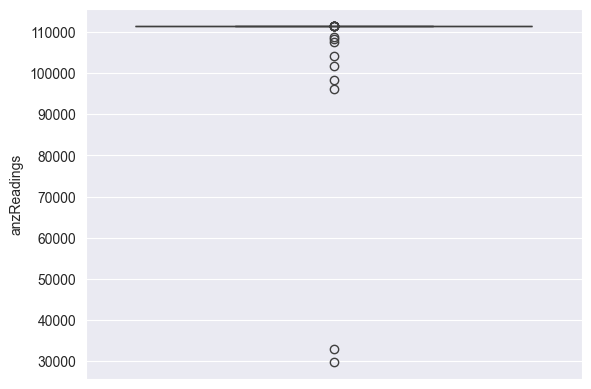

In [47]:
df = pd.read_sql_query("SELECT plz, COUNT(plz) anzReadings FROM smartmeter GROUP BY plz;", connection)
sns.boxplot(data=df['anzReadings'])
plt.show()